![translation.jpg](img/translation3.jpg)

# Lost in translation

### Nicolas Soler, 05 Dec, 2020

## Project

All the files relative to this project are available on the following Github repo:
https://github.com/nicocubi/lost_in_translation

### Introduction

Do you like reading? Some readers have a preference for books that were written in their mother tongue. Why is that? What is wrong with translated novels for instance? Are they too contrained by the source language to sound natural in the target language? Do you think you could detect if a particular piece of text is a translation? 

Some people claim that they can, let see how well __machines__ perform at this game.

### Objectives

We will start our journey on the __project Gutenberg__ website, a repository of public domain books in various languages (http://www.gutenberg.org/). 

From there will extract all the books written in Spanish languages in order to perform a __Natural Language Processing__ (NLP) analysis. The steps to follow are:

- data extraction using a dedicated API
- data wranggling and description
- data numerisation through NLP routines
- Construction of a classifier that will try to detect translated texts
- Construction of a Deep Learning classifer that will try to detect the source language

### Importing data manipulation and visualization libraries

In [1]:
%matplotlib inline
import os, glob, re
import json
import joblib
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("white")


#pd.set_option("max_rows", None)
pd.set_option('display.max_columns', None)

### Parameters

In [2]:
MAXLEN=300000 # Max length of a text document in number of characters
CHUNK_LEN=100 # Number of sentences contained in a chunk

# Regular expressions
wordreg=re.compile(r"[A-Za-záéíóñ]+")
spanishPunct= '¡!\"#$%&\'()*+,-./:;<=>¿?@[\\]^_`{|}~'

## 1) Data extraction

I used a Python library called Gutenberg 0.8.1 (https://pypi.org/project/Gutenberg/) available via the PyPI website, so easily installable with _pip_. The script written to download all Spanish books and metadata is provided into the _codigo_ folder of our GitHun repo.

In [3]:
# Recover all metadata downloaded as json

# list of metadata files downloaded from Gutenberg
ficheros = glob.glob("../data/metadata/*.json")
ficheros[:5]

['../data/metadata/55215.json',
 '../data/metadata/63600.json',
 '../data/metadata/18289.json',
 '../data/metadata/58103.json',
 '../data/metadata/13458.json']

In [4]:
# open each file and load the list of dictionaries it contains
librosDict = dict()
for f in ficheros:
    fname= os.path.basename(f).split('.')[0]  # ex: 55215
    with open(f) as fp:
        librosDict[fname] = json.load(fp)

In [5]:
# check
librosDict

{'55215': {'id': 55215,
  'author': ['Hawthorne, Nathaniel'],
  'title': ['Cuando la tierra era niña'],
  'language': ['es'],
  'subject': ['PZ',
   'BL',
   'Mythology, Greek -- Juvenile literature',
   'Mythology, Greek'],
  'rights': ['Public domain in the USA.']},
 '63600': {'id': 63600,
  'author': ['Mansilla, Lucio V.'],
  'title': ['Una Excursión a los Indios Ranqueles - Tomo 1'],
  'language': ['es'],
  'subject': ['Ranquel Indians',
   'F2801',
   'Argentina -- Description and travel'],
  'rights': ['Public domain in the USA.']},
 '18289': {'id': 18289,
  'author': ['Lozano, Pedro'],
  'title': ['Diario de un viage a la costa de la mar Magallanica'],
  'language': ['es'],
  'subject': ['Argentina -- Discovery and exploration',
   'F2801',
   'Patagonia (Argentina and Chile) -- Description and travel'],
  'rights': ['Public domain in the USA.']},
 '58103': {'id': 58103,
  'author': ['Girondo, Oliverio'],
  'title': ['20 poemas para ser leídos en el tranvía'],
  'language': ['es

In [6]:
# Transform this into a pandas DataFrame
df = pd.DataFrame(librosDict)
df = df.transpose()  # to have the book entries as rows

# We don't need the dict anymore
del librosDict

#Check
df.head()

,id,author,title,language,subject,rights
55215,55215,"[Hawthorne, Nathaniel]",[Cuando la tierra era niña],[es],"[PZ, BL, Mythology, Greek -- Juvenile literatu...",[Public domain in the USA.]
63600,63600,"[Mansilla, Lucio V.]",[Una Excursión a los Indios Ranqueles - Tomo 1],[es],"[Ranquel Indians, F2801, Argentina -- Descript...",[Public domain in the USA.]
18289,18289,"[Lozano, Pedro]",[Diario de un viage a la costa de la mar Magal...,[es],"[Argentina -- Discovery and exploration, F2801...",[Public domain in the USA.]
58103,58103,"[Girondo, Oliverio]",[20 poemas para ser leídos en el tranvía],[es],"[Argentine poetry, PQ]",[Public domain in the USA.]
13458,13458,[],"[Derroteros y viages à la Ciudad Encantada, ó ...",[es],"[Ciudad de los Césares (Legendary place), F305...",[Public domain in the USA.]


In [7]:
# And the column id is redundant with the index
df.drop('id',inplace=True,axis=1)

# Right now each record is a list, let's replace by a string (fileds separated by /)
for col in df.columns:
    df[col]= df[col].apply(lambda li: '/'.join(li))
    
#check the first 5 entries
df.head()

,author,title,language,subject,rights
55215,"Hawthorne, Nathaniel",Cuando la tierra era niña,es,"PZ/BL/Mythology, Greek -- Juvenile literature/...",Public domain in the USA.
63600,"Mansilla, Lucio V.",Una Excursión a los Indios Ranqueles - Tomo 1,es,Ranquel Indians/F2801/Argentina -- Description...,Public domain in the USA.
18289,"Lozano, Pedro",Diario de un viage a la costa de la mar Magall...,es,Argentina -- Discovery and exploration/F2801/P...,Public domain in the USA.
58103,"Girondo, Oliverio",20 poemas para ser leídos en el tranvía,es,Argentine poetry/PQ,Public domain in the USA.
13458,,"Derroteros y viages à la Ciudad Encantada, ó d...",es,Ciudad de los Césares (Legendary place)/F3051/...,Public domain in the USA.


In [8]:
# How many entries we have: 712
df.shape

(657, 5)

### Adding the full text to each entry

In [9]:
# Let's create a new column in the dataframe
df['text']=''

# Each book text has also been downloaded and stored in a different folder (same book id but extension .txt)
for f in glob.glob("../data/txt/*.txt"):
    fname= os.path.basename(f).split('.')[0]  # ex: 55215
    with open(f) as fp:
        df.loc[fname,'text'] = fp.read().lower() # change to lower case

# check: so far so god!
df.head()

,author,title,language,subject,rights,text
55215,"Hawthorne, Nathaniel",Cuando la tierra era niña,es,"PZ/BL/Mythology, Greek -- Juvenile literature/...",Public domain in the USA.,[imagen: _estrella_]\n\n\n ...
63600,"Mansilla, Lucio V.",Una Excursión a los Indios Ranqueles - Tomo 1,es,Ranquel Indians/F2801/Argentina -- Description...,Public domain in the USA.,santiago and the online distributed proofreadi...
18289,"Lozano, Pedro",Diario de un viage a la costa de la mar Magall...,es,Argentina -- Discovery and exploration/F2801/P...,Public domain in the USA.,images generously made available by the biblio...
58103,"Girondo, Oliverio",20 poemas para ser leídos en el tranvía,es,Argentine poetry/PQ,Public domain in the USA.,produced from images available at the internet...
13458,,"Derroteros y viages à la Ciudad Encantada, ó d...",es,Ciudad de los Césares (Legendary place)/F3051/...,Public domain in the USA.,team. this file was produced from images gener...


### Trying to know whether the book has been translated from the 'subject' field

In [10]:
df.subject.unique()

array(['PZ/BL/Mythology, Greek -- Juvenile literature/Mythology, Greek',
       'Ranquel Indians/F2801/Argentina -- Description and travel',
       'Argentina -- Discovery and exploration/F2801/Patagonia (Argentina and Chile) -- Description and travel',
       'Argentine poetry/PQ',
       'Ciudad de los Césares (Legendary place)/F3051/F2801/Chile -- Description and travel/Argentina -- Description and travel',
       "Cuba -- Description and travel/United States -- Description and travel/World's Columbian Exposition (1893 : Chicago, Ill.)/Mexico -- Description and travel/E151",
       'Spanish fiction -- 19th century/PQ',
       'Spain -- History -- Ferdinand VII, 1813-1833 -- Fiction/War stories/Historical fiction/PQ/Spain -- History -- Revolution, 1820-1823 -- Fiction',
       'Philosophy/B',
       'DP/Juana, la Loca, Queen of Castile, 1479-1555/Queens -- Spain -- Castile -- Biography',
       'PQ/Cooking -- Humor',
       'PQ/Spain -- Social life and customs -- Fiction',
       'Fi

We observe that when the book, has been translated, the term "Translations into" appears together with the original language, ex: 'French fiction -- Translations into Spanish/PQ',

In [11]:
# Extracting this info with a small function that retrieves the source language with a regular expression
# For example it would detect: Italian fiction -- Translations into Spanish 

langre= re.compile(r"(.*, )?((\w+ ){1,2})-- translations into spanish")

def isTranslated(subject):
    m = langre.match(subject.lower())
    if m:
        return m.group(2).split()[0] # captures the language name
    else:
        return 'spanish' 
    
# Now applying this function to the whole dataset
df['source']= df.subject.apply(isTranslated)

# changing 'american' to english
df.loc[df.source=='american','source']='english'

# check
df[df.source != 'spanish']

,author,title,language,subject,rights,text,source
29799,"Andreyev, Leonid",Los espectros: Novelas breves,es,"Fiction/PG/Short stories, Russian -- Translati...",Public domain in the USA.,transcriber's note:\n\n text enclosed betwee...,russian
29640,"About, Edmond",Germana,es,French fiction -- Translations into Spanish/PQ,Public domain in the USA.,biblioteca de la nación\n\nedmundo about\n\nge...,french
59686,"Shakespeare, William",Dramas de Guillermo Shakspeare [vol. 4],es,English drama -- Translations into Spanish/Sha...,Public domain in the USA.,produced from images available at the internet...,english
53207,"Shakespeare, William",Dramas de Guillermo Shakspeare [vol. 1],es,English drama -- Translations into Spanish/Sha...,Public domain in the USA.,online distributed proofreading team at http:/...,english
41161,"Verga, Giovanni",La vida en los campos: novelas cortas,es,"Short stories, Italian -- Translations into Sp...",Public domain in the USA.,(this file was transcribed from google-digitiz...,italian
26404,"About, Edmond",La nariz de un notario,es,French fiction -- Translations into Spanish/PQ,Public domain in the USA.,proofreading team at dp europe (http://dp.rast...,french
29105,"Nodier, Charles",El pintor de Salzburgo,es,French fiction -- Translations into Spanish/PQ...,Public domain in the USA.,online distributed proofreading team at\nhttp:...,french
26756,"De Roberto, Federico",Espasmo,es,Italian fiction -- Translations into Spanish/PQ,Public domain in the USA.,proofreading team at dp europe (http://dp.rast...,italian
26845,"Lecomte du Noüy, Hermine Oudinot",Incertidumbre,es,French fiction -- Translations into Spanish/PQ,Public domain in the USA.,biblioteca de «la nacion»\n\nh. l. n.\n\nincer...,french
46496,"Hawthorne, Nathaniel/Irving, Washington/Hale, ...","Cuentos Clásicos del Norte, Segunda Serie",es,American literature -- Translations into Spani...,Public domain in the USA.,produced from images available at the internet...,english


In [12]:
# For some reasons, those foreign authors have not been detected as such
foreign_authors={'Daudet, Alphonse':'french', 'Caro, Madame P.':'french','Eliot, George':'english',
                 'Hope, Anthony': 'english', 'Dourliac, Arthur': 'french', 'Irving, Washington':'english',
                 'Salgari, Emilio': 'italian', 'Fromentin, Eugène':'french', 'Halévy, Ludovic':'french',
                 'Dumas, Alexandre': 'french', 'Voltaire': 'french', 'Ponson du Terrail': 'french',
                 'Mancey, Claude': 'french', 'Dostoyevsky, Fyodor': 'russian', 'Le Sage, Alain René':'french',
                 'Dickens, Charles': 'english', 'Stevenson, Robert Louis': 'english', 'Conscience, Hendrik':'dutch',
                 'Doyle, Arthur Conan':'english', 'Theuriet, André':'french', 'Harte, Bret':'english'
                }

# Correct this
df.loc[df.author.isin(foreign_authors),'source']= df[df.author.isin(foreign_authors)].author.apply(lambda x:foreign_authors[x])

In [13]:
# check Spanish books
df[df.source == 'spanish']

,author,title,language,subject,rights,text,source
55215,"Hawthorne, Nathaniel",Cuando la tierra era niña,es,"PZ/BL/Mythology, Greek -- Juvenile literature/...",Public domain in the USA.,[imagen: _estrella_]\n\n\n ...,spanish
63600,"Mansilla, Lucio V.",Una Excursión a los Indios Ranqueles - Tomo 1,es,Ranquel Indians/F2801/Argentina -- Description...,Public domain in the USA.,santiago and the online distributed proofreadi...,spanish
18289,"Lozano, Pedro",Diario de un viage a la costa de la mar Magall...,es,Argentina -- Discovery and exploration/F2801/P...,Public domain in the USA.,images generously made available by the biblio...,spanish
58103,"Girondo, Oliverio",20 poemas para ser leídos en el tranvía,es,Argentine poetry/PQ,Public domain in the USA.,produced from images available at the internet...,spanish
13458,,"Derroteros y viages à la Ciudad Encantada, ó d...",es,Ciudad de los Césares (Legendary place)/F3051/...,Public domain in the USA.,team. this file was produced from images gener...,spanish
...,...,...,...,...,...,...,...
20930,"Guillemin, Amédée",Cosmografía,es,Stars/Solar system/QB,Public domain in the USA.,online distributed proofreading team at http:/...,spanish
49418,"Pérez de Ayala, Ramón","Las máscaras, vol. 2/2",es,Drama -- History and criticism/PN,Public domain in the USA.,produced from images available at the internet...,spanish
59154,"Alarcón, Pedro Antonio de",El Niño de la Bola: Novela,es,Spanish fiction -- 19th century/PQ,Public domain in the USA.,digital hispánica/biblioteca nacional de españ...,spanish
14995,"Pereda, José María de",Los Hombres de Pro,es,Fiction/PQ,Public domain in the USA.,proofreading team.\n\n\n\n\n\n\nobras completa...,spanish


In [14]:
# Keep only Spanish books which are fiction
def isFiction(row):
    if row.source != 'spanish':
        return True
    elif row.source=='spanish' and 'fiction' in row.subject.lower():
        return True
    else:
        return False

df=df[df.apply(isFiction,axis=1)]
df

,author,title,language,subject,rights,text,source
25074,"Estébanez Calderón, Serafín",Novelas y cuentos,es,Spanish fiction -- 19th century/PQ,Public domain in the USA.,colección universal\n\nn.os 46 y 47\n\ns. esté...,spanish
11070,"Pérez Galdós, Benito",La Fontana de Oro,es,"Spain -- History -- Ferdinand VII, 1813-1833 -...",Public domain in the USA.,online distributed proofreading team.\n\n\n\n\...,spanish
63414,"Pérez Galdós, Benito",Lo prohibido (tomo 2 de 2),es,PQ/Spain -- Social life and customs -- Fiction,Public domain in the USA.,online distributed proofreading team at https:...,spanish
29799,"Andreyev, Leonid",Los espectros: Novelas breves,es,"Fiction/PG/Short stories, Russian -- Translati...",Public domain in the USA.,transcriber's note:\n\n text enclosed betwee...,russian
53355,"Pérez Galdós, Benito",La novela en el tranvía,es,PQ/Spanish fiction/Madrid (Spain) -- Fiction,Public domain in the USA.,la novela en el tranvía\n\nb. pérez galdós (18...,spanish
...,...,...,...,...,...,...,...
48783,"Baroja, Pío",El Escuadrón del Brigante,es,"PQ/Spain -- History -- Napoleonic Conquest, 18...",Public domain in the USA.,nota del transcriptor:\n\n\n se ha respetado ...,spanish
59154,"Alarcón, Pedro Antonio de",El Niño de la Bola: Novela,es,Spanish fiction -- 19th century/PQ,Public domain in the USA.,digital hispánica/biblioteca nacional de españ...,spanish
24925,"Caro, Madame P.",Amar es vencer,es,PQ/Spanish fiction,Public domain in the USA.,biblioteca de «la nación»\n\nmadame p. caro\n\...,french
14995,"Pereda, José María de",Los Hombres de Pro,es,Fiction/PQ,Public domain in the USA.,proofreading team.\n\n\n\n\n\n\nobras completa...,spanish


In [15]:
# We need to filter more Spanish titles
df[df.source=='spanish'].author.unique()

array(['Estébanez Calderón, Serafín', 'Pérez Galdós, Benito',
       'Blasco Ibáñez, Vicente', 'Pereda, José María de',
       'Alas, Leopoldo', 'Cancela, Arturo', 'Baroja, Pío',
       'Palacio Valdés, Armando', 'Ortega y Gasset, José',
       'Picón, Jacinto Octavio', 'Portillo, Andrés',
       'Cervantes Saavedra, Miguel de', 'Alarcón, Pedro Antonio de',
       'Caballero, Fernán', 'Palma, Angélica', 'Unamuno, Miguel de',
       'Carrere, Emilio',
       'Ortega Munilla, J. (José)/San Martín, Bernardo Morales/Álvarez Quintero, Joaquín/Trigo, Felipe/Retana, Alvaro/San José, Diego/Gamero, Gutiérrez/Álvarez Quintero, Serafín/Blasco Ibáñez, Vicente/Hoyos y Vinent, Antonio de/Echegaray, José/Espina, Concha/Fernández-Flórez, Wenceslao',
       'Pardo Bazán, Emilia, condesa de', 'Fernández y González, Manuel',
       'Erckmann-Chatrian', 'Ohnet, Georges', 'Aimard, Gustave', '',
       'López, Lucio Vicente', 'Delicado, Francisco, active 16th century',
       'Díaz-Caneja, Guillermo', 'Bena

In [16]:
# Remove books in which there are several authors
authorlist1='Nogales, José/Dicenta, Joaquín/Baroja, Pío/Unamuno, Miguel de/Répide, Pedro de/León, Ricardo/Reyes, Arturo/Pérez Galdós, Benito/Darío, Rubén/Palacio Valdés, Armando/Benavente, Jacinto/Pardo Bazán, Emilia, condesa de/Mata, Pedro'
authorlist2='Ortega Munilla, J. (José)/San Martín, Bernardo Morales/Álvarez Quintero, Joaquín/Trigo, Felipe/Retana, Alvaro/San José, Diego/Gamero, Gutiérrez/Álvarez Quintero, Serafín/Blasco Ibáñez, Vicente/Hoyos y Vinent, Antonio de/Echegaray, José/Espina, Concha/Fernández-Flórez, Wenceslao'
df[(df.author==authorlist1) | (df.author==authorlist2)]

,author,title,language,subject,rights,text,source
41106,"Ortega Munilla, J. (José)/San Martín, Bernardo...","La voz de la conseja, t.2\r\nSelección de las ...",es,PQ/Spanish fiction,Public domain in the USA.,produced from images available at the internet...,spanish
40827,"Nogales, José/Dicenta, Joaquín/Baroja, Pío/Una...","La voz de la conseja, t.1\r\nSelección de las ...",es,PQ/Spanish fiction,Public domain in the USA.,produced from images available at the internet...,spanish


In [17]:
df.drop(['41106','40827'], inplace=True)

In [18]:
# OK, removed
df.loc[df.author=='Nogales, José/Dicenta, Joaquín/Baroja, Pío/Unamuno, Miguel de/Répide, Pedro de/León, Ricardo/Reyes, Arturo/Pérez Galdós, Benito/Darío, Rubén/Palacio Valdés, Armando/Benavente, Jacinto/Pardo Bazán, Emilia, condesa de/Mata, Pedro'].subject

Series([], Name: subject, dtype: object)

In [19]:
df[df.author=='Anonymous']

,author,title,language,subject,rights,text,source
320,Anonymous,Vida De Lazarillo De Tormes Y De Sus Fortunas ...,es,Spain -- Social conditions -- 16th century -- ...,Public domain in the USA.,"also known as ""lazarillo de tormes"" or\n""la vi...",spanish


In [20]:
df[df.author=='']

,author,title,language,subject,rights,text,source
15027,,La Novela Picaresca,es,"Picaresque literature, Spanish/PQ/Spanish fiction",Public domain in the USA.,biblioteca literaria del estudiante\n\ndirigid...,spanish


In [21]:
df.drop(['320','15027'],inplace=True)

In [22]:
langDict={'french':'fr', 'german':'de', 'italian':'it', 'spanish':'es', 'russian':'ru','english':'en'}

### Getting more books from elejandria

In [23]:
# That's good but not enough, we need to find more books translated into spanish
# Let's download more files from https://www.elejandria.com/, a fantastic resources where
# Spanish public domain books are available in PDF

# Extracting the text from a PDF
root="/home/nicolas/CODE/lostInTranslation/data/pdf"
#cmd = 'exiftool -Title="<TITLE>" -Author="<AUTHOR>" -Subject="<SOURCE_LANG>"" <PDF_FILE>'
directories= ('spanish', 'english', 'french', 'german', 'italian', 'russian')

for lang in directories:
    direct= os.path.join(root,lang)
    if os.path.exists(direct):
        # Set correct metadata for all files
        pdfFiles= glob.glob(os.path.join(direct,"*.pdf"))
        for pdf in pdfFiles:
            tmpdict=dict(subject='elejandria', rights='na', source=lang, language=langDict.get(lang,'na'))
            tmp = os.path.basename(pdf).split('.')[0].split('-')
            tmpdict['title'],tmpdict['author'] = tmp[0],tmp[1]
            
            #convert the pdf file into a text file
            txtFile=pdf.replace('.pdf','.txt')
            if not os.path.exists(txtFile):
                cmd= os.system("pdftotext "+pdf)
            
            # capturing the text
            with open(txtFile) as f:
                tmpdict['text'] = f.read().lower()
            
            # Now add this to the current dataframe
            df=df.append(pd.Series(tmpdict),ignore_index=True)

In [24]:
# check
df[df.source == 'russian']

,author,title,language,subject,rights,text,source
29799,"Andreyev, Leonid",Los espectros: Novelas breves,es,"Fiction/PG/Short stories, Russian -- Translati...",Public domain in the USA.,transcriber's note:\n\n text enclosed betwee...,russian
61851,"Dostoyevsky, Fyodor",El crimen y el castigo,es,Saint Petersburg (Russia) -- Fiction/PG/Psycho...,Public domain in the USA.,internet archive and the online distributed pr...,russian


In [25]:
# Try to select only the spanish books which are fiction
df['is_fiction'] = df.subject.apply(lambda s: 1 if "fiction" in s.lower() else 0)

# Also books from elejandria are all fiction
df.loc[df.subject=="elejandria",'is_fiction'] =1

#Work only with the fiction books from now
df=df[df.is_fiction==1]

In [26]:
df.shape

(294, 8)

In [27]:
# Let's replace _ by , in column author and space in column title
df.author = df.author.apply(lambda x: x.replace('_',', '))
df.title= df.title.apply(lambda x:x.replace('_', ' '))

/home/nicolas/anaconda3/envs/gutemberg/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [28]:
# Checka how many books of each language there are
df.source.value_counts()

spanish    255
french      23
english      9
italian      3
russian      2
dutch        1
german       1
Name: source, dtype: int64

<AxesSubplot:>

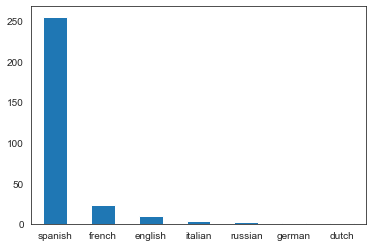

In [29]:
# We might need to reduce the number of Spanish books
df.source.value_counts().sort_values(ascending=False).plot.bar(rot=0)

### Reducing the number of Spanish books

In [30]:
df[df.source=='spanish'].author.unique()

array(['Estébanez Calderón, Serafín', 'Pérez Galdós, Benito',
       'Blasco Ibáñez, Vicente', 'Pereda, José María de',
       'Alas, Leopoldo', 'Cancela, Arturo', 'Baroja, Pío',
       'Palacio Valdés, Armando', 'Ortega y Gasset, José',
       'Picón, Jacinto Octavio', 'Portillo, Andrés',
       'Cervantes Saavedra, Miguel de', 'Alarcón, Pedro Antonio de',
       'Caballero, Fernán', 'Palma, Angélica', 'Unamuno, Miguel de',
       'Carrere, Emilio', 'Pardo Bazán, Emilia, condesa de',
       'Fernández y González, Manuel', 'Erckmann-Chatrian',
       'Ohnet, Georges', 'Aimard, Gustave', 'López, Lucio Vicente',
       'Delicado, Francisco, active 16th century',
       'Díaz-Caneja, Guillermo', 'Benavente, Jacinto', 'Valera, Juan',
       'Bunge, Carlos O. (Carlos Octavio)', 'Trigo, Felipe',
       'Lastarria, José Victorino', 'Zamacois, Eduardo',
       'Queirós, Eça de', 'Gil y Carrasco, Enrique',
       'Pérez de Ayala, Ramón', 'Coloma, Luis', 'Payró, Roberto Jorge',
       'Gómez de 

In [31]:
df[df.source=='spanish'].author.nunique()

72

### Choose only one book of each of the 83 Spanish authors

In [32]:
# Filtering to keep only foreign books or books from these authors
presentAuthors=set()
df2= pd.DataFrame(columns=df.columns)

for i,row in df.iterrows():
    if (row.source != 'spanish'):
        df2=df2.append(row,ignore_index=True)
    elif row.author not in presentAuthors:
        df2=df2.append(row,ignore_index=True)
        presentAuthors.add(row.author)
df2

,author,title,language,subject,rights,text,source,is_fiction
0,"Estébanez Calderón, Serafín",Novelas y cuentos,es,Spanish fiction -- 19th century/PQ,Public domain in the USA.,colección universal\n\nn.os 46 y 47\n\ns. esté...,spanish,1
1,"Pérez Galdós, Benito",La Fontana de Oro,es,"Spain -- History -- Ferdinand VII, 1813-1833 -...",Public domain in the USA.,online distributed proofreading team.\n\n\n\n\...,spanish,1
2,"Andreyev, Leonid",Los espectros: Novelas breves,es,"Fiction/PG/Short stories, Russian -- Translati...",Public domain in the USA.,transcriber's note:\n\n text enclosed betwee...,russian,1
3,"Blasco Ibáñez, Vicente","La araña negra, t. 5/9",es,Jesuits -- Spain -- History -- 19th century --...,Public domain in the USA.,produced from images available at the internet...,spanish,1
4,"Pereda, José María de",El sabor de la tierruca,es,Spanish fiction -- 19th century/PQ,Public domain in the USA.,distributed proofreading team at dp-test itali...,spanish,1
...,...,...,...,...,...,...,...,...
106,"Larreta, Enrique",La gloria de don Ramiro\nuna vida en tiempos d...,es,"Spain -- History -- Philip II, 1556-1598 -- Fi...",Public domain in the USA.,biblioteca de «la nacion»\n\nenrique larreta\n...,spanish,1
107,"Daudet, Alphonse",Cartas de mi molino,es,France -- Social life and customs -- Fiction/PQ,Public domain in the USA.,biblioteca de «la nación»\n\nalfonso daudet\n\...,french,1
108,"Eliot, George",Silas Marner,es,England -- Fiction/Adopted children -- Fiction...,Public domain in the USA.,proofreading team at dp europe (http://dp.rast...,english,1
109,"Caro, Madame P.",Amar es vencer,es,PQ/Spanish fiction,Public domain in the USA.,biblioteca de «la nación»\n\nmadame p. caro\n\...,french,1


In [33]:
df2.source.value_counts()

spanish    72
french     23
english     9
italian     3
russian     2
german      1
dutch       1
Name: source, dtype: int64

In [34]:
df=df2

In [35]:
# Remove the Dutch book
df.drop(df[df.source=='dutch'].index,inplace=True)

### Final check by language

In [36]:
# Check for books that have more than one entry for SPANISH
df[df.source=='spanish']

,author,title,language,subject,rights,text,source,is_fiction
0,"Estébanez Calderón, Serafín",Novelas y cuentos,es,Spanish fiction -- 19th century/PQ,Public domain in the USA.,colección universal\n\nn.os 46 y 47\n\ns. esté...,spanish,1
1,"Pérez Galdós, Benito",La Fontana de Oro,es,"Spain -- History -- Ferdinand VII, 1813-1833 -...",Public domain in the USA.,online distributed proofreading team.\n\n\n\n\...,spanish,1
3,"Blasco Ibáñez, Vicente","La araña negra, t. 5/9",es,Jesuits -- Spain -- History -- 19th century --...,Public domain in the USA.,produced from images available at the internet...,spanish,1
4,"Pereda, José María de",El sabor de la tierruca,es,Spanish fiction -- 19th century/PQ,Public domain in the USA.,distributed proofreading team at dp-test itali...,spanish,1
5,"Alas, Leopoldo",La Regenta,es,PQ/Married people -- Spain -- Fiction/Spain --...,Public domain in the USA.,la regenta\n\npor\n\nleopoldo alas «clarín»\n\...,spanish,1
...,...,...,...,...,...,...,...,...
98,"Riva Palacio, Vicente","Monja y casada, vírgen y mártir",es,"PQ/Mexico -- History -- Spanish colony, 1540-1...",Public domain in the USA.,"[illustration: monja y casada, virgen y martir...",spanish,1
99,"Valera, Juan/Longus",Dafnis y Cloe; leyendas del antiguo Oriente (f...,es,Spanish literature/PQ/Daphnis (Greek mythology...,Public domain in the USA.,produced from images available at the internet...,spanish,1
100,"Delgado, Rafael",Angelina\n(novela mexicana),es,PQ/Man-woman relationships -- Fiction,Public domain in the USA.,colección de escritores americanos dirigida po...,spanish,1
103,"Espinel, Vicente",Vida del escudero Marcos de Obregón,es,"Spanish fiction -- Classical period, 1500-1700...",Public domain in the USA.,nota de transcripción\n\n * las cursivas se m...,spanish,1


In [37]:
# This one contains too much English text
df.drop(0,inplace=True)

In [38]:
# Check whether books have images inside
df.loc[104,'text']

'en esta edición se han mantenido las convenciones ortográficas del\noriginal, incluyendo las variadas normas de acentuación presentes en el\ntexto. (nota del transcriptor)\n\n\n             la guardia blanca\n\n     _novela histórica escrita en inglés_\n\n                   por\n\n             a. conan doyle\n\n         traducida al castellano\n\n            por juan l. iribas\n\n                nueva york\n          d. appleton y compañía\n                 editores\n                   1896\n\n              copyright, 1896,\n\n        by d. appleton and company.\n\n\n_la propiedad de esta obra está protegida por la ley en\nvarios países, donde se perseguirá á los que la\nreproduzcan fraudulentamente._\n\n\n\n\ná quien leyere.\n\n\nen la moderna literatura inglesa, menos quizás que en ninguna otra,\nespera encontrar el lector obras que por su carácter y forma le\nrecuerden las narraciones históricas de tipos caballerescos, empresas\naventuradas y altas hazañas, que han inmortalizado lo

In [39]:
# Check for books that have more than one entry for foreign languages
df[df.source=='french']

,author,title,language,subject,rights,text,source,is_fiction
8,"About, Edmond",Germana,es,French fiction -- Translations into Spanish/PQ,Public domain in the USA.,biblioteca de la nación\n\nedmundo about\n\nge...,french,1
31,"About, Edmond",La nariz de un notario,es,French fiction -- Translations into Spanish/PQ,Public domain in the USA.,proofreading team at dp europe (http://dp.rast...,french,1
33,"Le Sage, Alain René",Historia de Gil Blas de Santillana: Novela (Vo...,es,"PQ/Blas, Gil (Fictitious character) -- Fiction...",Public domain in the USA.,nota del transcriptor:\n\n\n se ha respetado ...,french,1
34,"Nodier, Charles",El pintor de Salzburgo,es,French fiction -- Translations into Spanish/PQ...,Public domain in the USA.,online distributed proofreading team at\nhttp:...,french,1
38,"Mancey, Claude",Las Solteronas,es,PQ/Single women -- Fiction,Public domain in the USA.,biblioteca de «la nacion»\n\nclaude mancey\n\n...,french,1
44,Voltaire,"Candido, o El Optimismo",es,Optimism -- Fiction/Satire/PQ,Public domain in the USA.,charles franks and the online distributed proo...,french,1
46,"Lecomte du Noüy, Hermine Oudinot",Incertidumbre,es,French fiction -- Translations into Spanish/PQ,Public domain in the USA.,biblioteca de «la nacion»\n\nh. l. n.\n\nincer...,french,1
47,Ponson du Terrail,La cuerda del ahorcado\nÚltimas aventuras de R...,es,Fiction/PQ,Public domain in the USA.,la cuerda\n\ndel ahorcado\n\nparis--tip. de ga...,french,1
48,Voltaire,"Zadig, ó El Destino, Historia Oriental",es,French literature -- 18th century/Manners and ...,Public domain in the USA.,online distributed proofreading team.\n\n\n\n\...,french,1
50,"Dumas, Alexandre",Amaury,es,PQ/Tuberculosis -- Fiction,Public domain in the USA.,amaury\n\npor\n\nalejandro dumas\n\ntraducción...,french,1


In [40]:
# Check for books that have more than one entry for English
df[df.source=='english']

,author,title,language,subject,rights,text,source,is_fiction
10,"Stevenson, Robert Louis",La isla del tesoro,es,Treasure troves -- Fiction/Pirates -- Fiction/...,Public domain in the USA.,"la isla del tesoro\n\n ""=la guardia blanca...",english,1
27,"Dickens, Charles",Una historia de dos ciudades,es,Paris (France) -- History -- 1789-1799 -- Fict...,Public domain in the USA.,online distributed proofreading team at https:...,english,1
57,"Stevenson, Robert Louis",El caso extraño del Doctor Jekyll,es,Science fiction/Self-experimentation in medici...,Public domain in the USA.,online distributed proofreading team at https:...,english,1
66,"Dickens, Charles",Los Ladrones de Londres,es,London (England) -- Fiction/Criminals -- Ficti...,Public domain in the USA.,project id: coalesce/2017/117 (irish research ...,english,1
84,"Harte, Bret",Bocetos californianos,es,PS/California -- Social life and customs -- Fi...,Public domain in the USA.,biblioteca de «la nacion»\n\nfrancisco bret ha...,english,1
91,"Irving, Washington",Cuentos de la Alhambra,es,"Alhambra (Granada, Spain)/PS/Palaces -- Spain ...",Public domain in the USA.,distributed proofreading team at dp-test itali...,english,1
102,"Hope, Anthony",El prisionero de Zenda,es,British -- Foreign countries -- Fiction/Impost...,Public domain in the USA.,proofreading team at dp europe (http://dp.rast...,english,1
104,"Doyle, Arthur Conan",La guardia blanca\nnovela histórica escrita en...,es,Archers -- Fiction/Knights and knighthood -- F...,Public domain in the USA.,en esta edición se han mantenido las convencio...,english,1
108,"Eliot, George",Silas Marner,es,England -- Fiction/Adopted children -- Fiction...,Public domain in the USA.,proofreading team at dp europe (http://dp.rast...,english,1


In [41]:
# Check for books that have more than one entry for German language
df[df.source=='german']

,author,title,language,subject,rights,text,source,is_fiction
101,"Sudermann, Hermann",El molino silencioso; Las bodas de Yolanda,es,German fiction -- Translations into Spanish/PT,Public domain in the USA.,biblioteca de «la nacion»\n\nhermann sudermann...,german,1


In [42]:
# Check for books that have more than one entry for Russian
df[df.source=='russian']

,author,title,language,subject,rights,text,source,is_fiction
2,"Andreyev, Leonid",Los espectros: Novelas breves,es,"Fiction/PG/Short stories, Russian -- Translati...",Public domain in the USA.,transcriber's note:\n\n text enclosed betwee...,russian,1
17,"Dostoyevsky, Fyodor",El crimen y el castigo,es,Saint Petersburg (Russia) -- Fiction/PG/Psycho...,Public domain in the USA.,internet archive and the online distributed pr...,russian,1


In [43]:
# Check for books that have more than one entry for Italian
df[df.source=='italian']

,author,title,language,subject,rights,text,source,is_fiction
30,"Verga, Giovanni",La vida en los campos: novelas cortas,es,"Short stories, Italian -- Translations into Sp...",Public domain in the USA.,(this file was transcribed from google-digitiz...,italian,1
45,"De Roberto, Federico",Espasmo,es,Italian fiction -- Translations into Spanish/PQ,Public domain in the USA.,proofreading team at dp europe (http://dp.rast...,italian,1
72,"Salgari, Emilio","Los pescadores de ""Trépang""",es,Adventure stories/PQ/Oceania -- Fiction,Public domain in the USA.,biblioteca calleja\n\n\n\n\nemilio salgari\n\n...,italian,1


### We're ready to proceed! Reset the index

<AxesSubplot:>

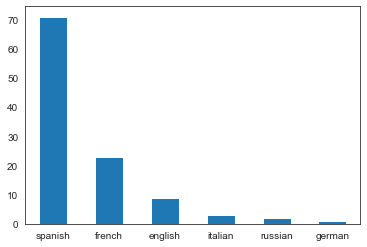

In [44]:
# OK we are more or less balance in terms of Spanish vs non-spanish books here
df.source.value_counts().plot.bar(rot=0)

In [45]:
df.source.value_counts()

spanish    71
french     23
english     9
italian     3
russian     2
german      1
Name: source, dtype: int64

In [46]:
df['original_es']=df.source.apply(lambda x:1 if x=='spanish'else 0)

In [47]:
# 111 translated books vs 91 Spanish books
df.original_es.value_counts()

1    71
0    38
Name: original_es, dtype: int64

In [48]:
# Removing line returns
df['text']=df.text.apply(lambda x:x.replace('\n',' ').replace('  ',' '))

# and other symbols
df['text']=df.text.apply(lambda x:x.replace('__',' ').replace('  ',' '))
df['text']=df.text.apply(lambda x:x.replace('--',' ').replace('  ',' '))
df['text']=df.text.apply(lambda x:x.replace('_','').replace('  ',' '))
df['text']=df.text.apply(lambda x:x.replace('*','').replace('  ',' '))
df['text']=df.text.apply(lambda x:x.replace('=','').replace('  ',' '))

### Extracting basic text features

Now that we have removed punctuation, for each document:
- word count
- character count
- punctuation count
- nword /sentence count
- ncharacter/sentence count
- average word length
- average sentence length

In [49]:
# Number of words, characters

def countPunct(text):
    return len(list(filter(lambda c: c in spanishPunct, text)))

def nWordsChar(text,n,m):
    """Extract words only (no number or punctuation) and returns basic features
       also returns the proportion of words with nchar<=n and those with nchar>=m
    """
    listWords = wordreg.findall(text)
    nsmall=0
    nbig=0
    nchar=0
    
    # Number for words
    nwords= len(listWords)
#     print("TEXT",text)
#     print("\nLISTWORD",listWords)
#     print("\nNWORDS",nwords)
    
    
    # Number of characters
    for w in listWords:
        l=len(w)
        nchar += l
        if l<=n:
            nsmall+=1
        elif l>=m:
            nbig+=1
    #variance in number of characters
    varwlength= np.var([len(w) for w in listWords]) if len(listWords)>1 else 0
    
    # Average word length
    avwlength= nchar/nwords if nwords>0 else 0
    
    # Punctuation count
    npunct= countPunct(text)
    
    # Number of exclamations
    nExclam= text.count('!') + text.count('¡')
    
    # Number of interrogations
    nInterro = text.count('¿') + text.count('?')
    
    # Proportion of punctuation signs
    fpunct= npunct/nchar if nchar>0 else 0
                
    # proportion of small words
    fsmallW= nsmall/nwords if nwords>0 else 0
    
    # proportion of long words
    flongW= nbig/nwords if nwords>0 else 0
    
    # proportion of interrogation marks
    fQuestions= nInterro/nchar if nchar>0 else 0
    
    # proportion of exclamation marks
    fExclam= nExclam/nchar if nchar>0 else 0
    
    return nwords, nchar, avwlength, varwlength, fpunct , fsmallW ,flongW, fQuestions, fExclam
    
def findNextDot(text,index):
    """Given a text and a stop index, it finds the next closest column (.) and returns the index of the next character"""
    for i in range(index,len(text)):
        if text[i] == '.':
            return i+2 # Beginning of a new sentence
        
def truncateText(text,lim):
    """Truncate a text to lim characters, ends on a column"""
    if len(text)<=lim:
        return text
    else:
        return text[:findNextDot(text,lim)-1]

In [50]:
# Remove the first 1000 characters of each text
df['text']=df.text.apply(lambda t:t[findNextDot(t,1000):])

In [51]:
# check
print(df.iloc[7].title)
df.iloc[7].text

Germana


"en el fondo del patio, a la derecha, una amplia escalinata resguardada por una marquesina, conduce al vestíbulo y a la gran escalera. la planta baja y el primer piso están ocupados por el barón únicamente, que disfruta sin compartirlo con nadie un vasto jardín, limitado por otros jardines, y poblado de urracas, mirlos y ardillas que van y vienen de ése a los otros en completa libertad, como si se tratara de habitantes de un bosque y no de ciudadanos de parís. las armas de los sanglié, pintadas en negro, se descubren en todas las paredes del vestíbulo. son un jabalí de oro en un campo de gules. el escudo tiene por soporte dos lebreles, y está rematado con el penacho de barón con esta leyenda: sang lié au roy[a]. como media docena de lebreles vivos, agrupados según su capricho, se aburren al pie de la escalera, mordisquean las verónicas floridas en los vasos del japón o se tienden sobre la alfombra alargando la cabeza serpentina. los lacayos, sentados en banquetas de beauvais, cruzan so

In [52]:
# Get a tuple with all those basic features
n=1  # max len of small words
m=14  # min len of big words
df['num_feat']=df.text.apply(lambda t:nWordsChar(t,n,m))

# Making the single feature colums
df['nWords']=df.num_feat.apply(lambda t:t[0])
df['nChar']=df.num_feat.apply(lambda t:t[1])
df['avWordLen']=df.num_feat.apply(lambda t:t[2])
df['varWordLen']=df.num_feat.apply(lambda t:t[3])
df['fPunct']=df.num_feat.apply(lambda t:t[4])
df['fSmallWords']=df.num_feat.apply(lambda t:t[5])
df['fBigWords']=df.num_feat.apply(lambda t:t[6])
df['fInterro']=df.num_feat.apply(lambda t:t[7])
df['fExclam']=df.num_feat.apply(lambda t:t[8])

df.drop('num_feat',axis=1,inplace=True)
df.head()

,author,title,language,subject,rights,text,source,is_fiction,original_es,nWords,nChar,avWordLen,varWordLen,fPunct,fSmallWords,fBigWords,fInterro,fExclam
1,"Pérez Galdós, Benito",La Fontana de Oro,es,"Spain -- History -- Ferdinand VII, 1813-1833 -...",Public domain in the USA.,el sobrino de coletilla vii. la voz interior v...,spanish,1,1,125928,568489,4.514397,7.203878,0.041909,0.061615,0.002787,0.003717,0.002289
2,"Andreyev, Leonid",Los espectros: Novelas breves,es,"Fiction/PG/Short stories, Russian -- Translati...",Public domain in the USA.,"en 1894, cansado de luchar, desesperado, inten...",russian,1,0,41480,193590,4.667068,7.608443,0.054156,0.062874,0.003230,0.004107,0.007356
3,"Blasco Ibáñez, Vicente","La araña negra, t. 5/9",es,Jesuits -- Spain -- History -- 19th century --...,Public domain in the USA.,"alvarez, que era el secretario de la junta mil...",spanish,1,1,56871,269842,4.744808,8.447599,0.032626,0.067890,0.006348,0.001527,0.002009
4,"Pereda, José María de",El sabor de la tierruca,es,Spanish fiction -- 19th century/PQ,Public domain in the USA.,"y no voy á hablarte de él porque su fama, que ...",spanish,1,1,85025,368410,4.332961,6.808326,0.044117,0.074366,0.002305,0.002128,0.004107
5,"Alas, Leopoldo",La Regenta,es,PQ/Married people -- Spain -- Fiction/Spain --...,Public domain in the USA.,esto que digo de visitar talleres ajenos no si...,spanish,1,1,309110,1392002,4.503258,6.989681,0.045900,0.060584,0.002041,0.002400,0.002798


### Visualization of the basic variables

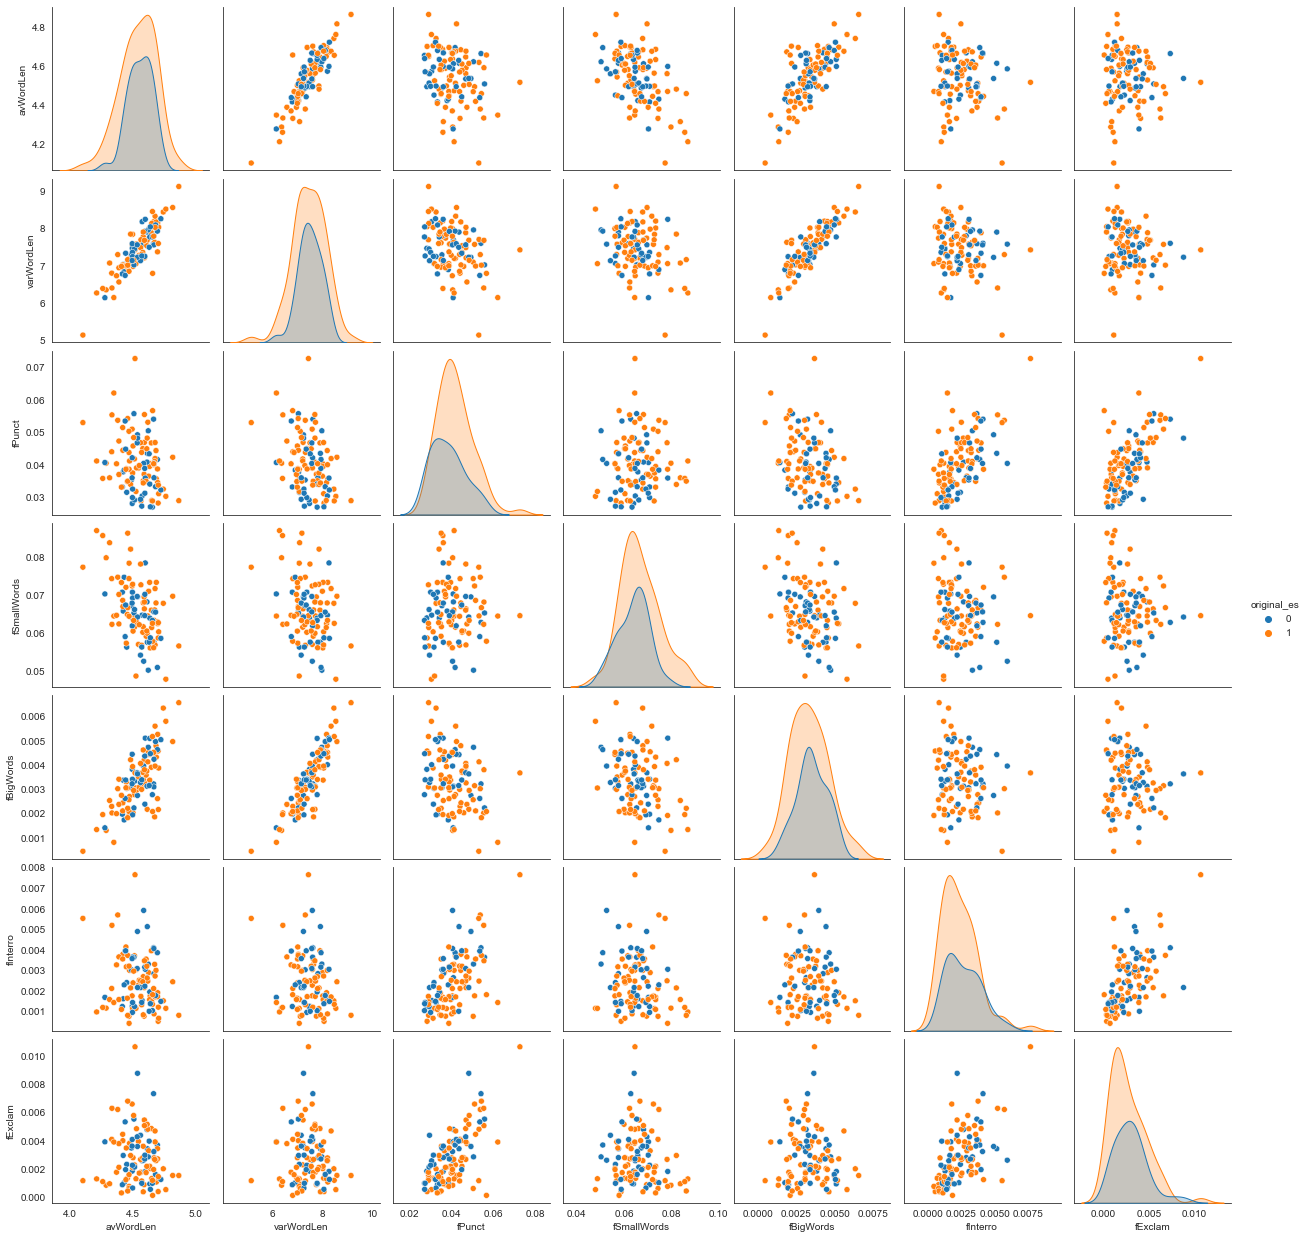

In [54]:
# using Seaborn's pairplot
subdf= df[['avWordLen','varWordLen', 'fPunct', 'fSmallWords', 'fBigWords', 'original_es','fInterro', 'fExclam']]
sns.pairplot(subdf, hue='original_es')

### Preliminary analysis
- The factor that distinguishes the most the two categories is the ratio __n_punctuation_signs / nwords__, which seems to be slightly higher for original spanish books
- If we look at the fraction of words of only one letter, we can see that translated books tend to have a bit more of them
- Then proportion of big words doesn't seem to allow discrimination here
- average word length is a bit bigger for original spanish books
- There tend to be more questions in translated books

### Projection in 2D (PCA)

In [55]:
# Standardizing the data
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

basic_features= ['avWordLen','varWordLen', 'fPunct', 'fSmallWords','fInterro']
X= df[basic_features].values
X = StandardScaler().fit_transform(X)

In [56]:
# Let's check whether the normalized data has a mean of zero and a standard deviation of one.
print(np.mean(X,axis=0),np.std(X,axis=0))

[-1.74681880e-15  1.42597453e-17  2.44452776e-16  6.29465898e-16
 -3.66679164e-17] [1. 1. 1. 1. 1.]


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

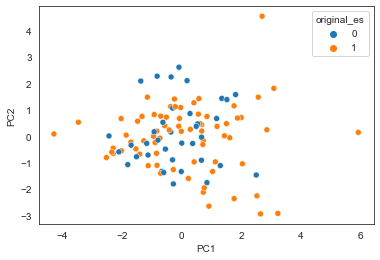

In [57]:
pca=PCA(n_components=2)
#pca = TSNE(n_components=2)
PCs=pca.fit_transform(X)

# retransform into a df
dfPC=pd.DataFrame(PCs,columns=['PC1','PC2'], index=df.index)
dfPC=pd.concat([dfPC,df[['source','original_es']]],axis=1)

sns.scatterplot(data=dfPC,x='PC1',y='PC2',hue='original_es')

## Dividing each text in chunk of 100 sentences

### Truncating texts
Otherwise the subsequent tokenization process is hard to achieve
Let's set a maximum length of 500 000 characters

In [58]:
# Remove books for which the text is too long
df['text']=df.text.apply(lambda t:truncateText(t,MAXLEN))
df.head()
df.iloc[0].text

'el sobrino de coletilla vii. la voz interior viii. hoy llega ix. los primeros pasos x. la primera batalla xi. la tragedia de los gracos xii. la batalla de platerías xiii. no llega el esperado. llegada de un importuno xiv. la determinación xv. las tres ruinas xvi. el siglo décimoctavo xvii. el sueño del liberal xviii. diálogo entre ayer y hoy xix. el abate xx. bozmediano xxi. ¡libre! xxii. el vía-crucis de lázaro xxiii. la inquisición xxiv. rosa mística xxv. virgo prudentísima xxvi. los disidentes de la fontana xxvii. se queda sola xxviii. el ridículo xxix. las horas fatales xxx. virgo fidelis xxxi. la reunión misteriosa xxxii. la fontanilla xxxiii. las arpías se ponen tristes xxxiv. el complot. triunfo de lázaro xxxv. el bonete del nuncio xxxvi. aclaraciones xxxvii. el vía-crucis de clara xxxviii. continuación del vía-crucis xxxix. un momento de calma xl. el gran atentado xli. fernando el deseado xlii. virgo potens xliii. conclusión capítulo primero #la carrera de san jerónimo en 1821

### Tokenizing each text

#### Using Spacy to break the text into sentences, lemmatize etc

Using the __es_core_news_md__ of the spacy library here (conda install spacy, 45MB)
install it via command line 
    python -m spacy download es_core_news_md

In [59]:
import spacy

# loading the spanish medium model
nlp= spacy.load('es_core_news_md')

In [60]:
# Tokenize the whole document and divide it into sentences (Span objects, 10 ~ 15min)
# And remove the first 10 sentence at the beginning and at the end
nlp.max_length=MAXLEN +1000
df.text= df.text.apply(lambda text: [s for s in nlp(text).sents])

In [61]:
# useful functions
def span2lemma(someSpan):
    """Lemmatizes a span"""
    return ' '.join([w.lemma_ for w in someSpan if len(w.text.strip())>0 and (not w.is_stop) and w.pos_!='PUNCT'])

def span2pos(someSpan):
    """Coarse-grained part of speech"""
    return ' '.join([w.pos_ for w in someSpan if len(w.text.strip())>0 and (not w.is_stop) and w.pos_!='PUNCT'])

def span2tag(someSpan):
    """Fine-grained part of speech"""
    return ' '.join([w.tag_ for w in someSpan if len(w.text.strip())>0 and (not w.is_stop) and w.pos_!='PUNCT'])
    
def span2dep(someSpan):
    """Syntaxic dependency"""
    return ' '.join([w.dep_ for w in someSpan if len(w.text.strip())>0 and (not w.is_stop) and w.pos_!='PUNCT'])

def span2grammar(someSpan):
    """pos_dep word"""
    return ' '.join([w.pos_+'_'+w.dep_ for w in someSpan if len(w.text.strip())>0 and w.pos_!='PUNCT'])

# aggregating ten sentences together
def aggrItems(spanList,chunk_len=5):
    """
    Aggregates CHUNL_LEN sentences together in a single chunk as the unit
    and FOR EACH CHUNK, retrieves the following figures:
    - 
    - Number of words
    - Number of chars
    - Number of small and long words
    - n_punct/n_char ratio
    - mean and variance of the number of words per sentence
    - mean and variance of the number of chars per sentence
    - mean and variance of the number of punct per sentence
    - mean and variance of the number of small and long words per sentence
    
    OUTPUT TUPLE: 21 features as a tuple (3 times 7 features: whole chunk, mean over all chunk sentences, variance over sentences)
    
    nWords, nChars, avWordLen, varWordlen, fPunct, nSmallWords, nLongWords
    nWordsMEAN_SENT, nCharsMEAN_SENT, avWordLenMEAN_SENT, varWordlenMEAN_SENT, fPunctMEAN_SENT, nSmallWordsMEAN_SENT, nLongWordsMEAN_SENT
    nWordsVAR_SENT, nCharsVAR_SENT, avWordLenVAR_SENT, varWordlenVAR_SENT, fPunctVAR_SENT, nSmallWordsVAR_SENT, nLongWordsVAR_SENT
    """
    outList=[]
    for i in range(0,len(spanList),chunk_len):
        remaining_len= len(spanList) -i
        
        # CHUNK of N sentences
        if remaining_len>chunk_len:
            tmplistSpan=spanList[i:i+chunk_len]
            tmplist = [sp.text for sp in tmplistSpan]
            chunk_text=' '.join(tmplist)
            
            # get numerical features of the whole chunk
            len_smallW=1
            len_longW=10
            
            (nwords, nchar, avwlength, varwlength, 
             fpunctchar, fsmall ,flong, _, _) = nWordsChar(chunk_text,len_smallW,len_longW)
            
            # get the same numerical features per sentence 
            # (so that we get mean and variance of them along the N sentences composing the chunk)
            sentenceFeatures = dict(nwordL= [],
                                    ncharL= [],
                                    avwordlL= [],
                                    varwlengthL= [],
                                    npunctL= [],
                                    nsmallWL= [],
                                    nlongWL= []
                                   )
            
            for phrase in tmplist:
                if len(phrase)>3: # 3 characters at least
                    (nwordstmp, nchartmp, avwlengthtmp, varwlengthtmp, 
                     fpunctchartmp, fsmalltmp ,flongtmp, _, _) = nWordsChar(phrase,len_smallW,len_longW)
                    
                    # debug
                    if avwlengthtmp == np.nan:
                        PRINT("ERROR")
                        return
                    
                    sentenceFeatures['nwordL'].append(nwordstmp)
                    sentenceFeatures['ncharL'].append(nchartmp)
                    sentenceFeatures['avwordlL'].append(avwlengthtmp)
                    sentenceFeatures['varwlengthL'].append(varwlengthtmp)
                    sentenceFeatures['npunctL'].append(fpunctchartmp)
                    sentenceFeatures['nsmallWL'].append(fsmalltmp)
                    sentenceFeatures['nlongWL'].append(flongtmp)
                             
            
            # Output tuple
            out_tuple= tuple([nwords, nchar, avwlength, varwlength,fpunctchar, fsmall ,flong]
                        + [np.mean(li) for li in sentenceFeatures.values()]
                        + [np.var(li) for li in sentenceFeatures.values()] + [tmplistSpan]
                            )
            
            # Add the text to the list of aggregated sentences
            outList.append(out_tuple)
            
        # Stop when not enough sentences are availabale to build a chunk
        else:
            #outList.append(' '.join(someList[i:]))
            pass
        
    return outList

In [62]:
# Aggregate in chunks of N sentences and calculate the chunk features
# The chunk text is the last element of the tuple
df['chunk_features'] = df.text.apply(lambda li: aggrItems(li,chunk_len=CHUNK_LEN))

After dividing the text in chunks of size N sentences, we can calculate the following features
- Mean and variance of number of words per chunk.
- Mean and variance of number of SMALL words per chunk.
- Mean and variance of number of LONG words per chunk.
- Mean and variance of word length per chunk
- Mean and variance of Number of punctuation signs per chunk.
- etc

The list of SPANS is kept as the last item of the tuple for further processing with Spacy

In [63]:
df.head()

,author,title,language,subject,rights,text,source,is_fiction,original_es,nWords,nChar,avWordLen,varWordLen,fPunct,fSmallWords,fBigWords,fInterro,fExclam,chunk_features
1,"Pérez Galdós, Benito",La Fontana de Oro,es,"Spain -- History -- Ferdinand VII, 1813-1833 -...",Public domain in the USA.,"[(el, sobrino, de, coletilla, vii, .), (la, vo...",spanish,1,1,125928,568489,4.514397,7.203878,0.041909,0.061615,0.002787,0.003717,0.002289,"[(2218, 10553, 4.757889990982868, 8.5504900474..."
2,"Andreyev, Leonid",Los espectros: Novelas breves,es,"Fiction/PG/Short stories, Russian -- Translati...",Public domain in the USA.,"[(en, 1894, ,, cansado, de, luchar, ,, desespe...",russian,1,0,41480,193590,4.667068,7.608443,0.054156,0.062874,0.003230,0.004107,0.007356,"[(2114, 9831, 4.65042573320719, 7.699462921873..."
3,"Blasco Ibáñez, Vicente","La araña negra, t. 5/9",es,Jesuits -- Spain -- History -- 19th century --...,Public domain in the USA.,"[(alvarez, ,, que, era, el, secretario, de, la...",spanish,1,1,56871,269842,4.744808,8.447599,0.032626,0.067890,0.006348,0.001527,0.002009,"[(1869, 8832, 4.725521669341894, 8.30828925434..."
4,"Pereda, José María de",El sabor de la tierruca,es,Spanish fiction -- 19th century/PQ,Public domain in the USA.,"[(y, no, voy, á, hablarte, de, él, porque, su,...",spanish,1,1,85025,368410,4.332961,6.808326,0.044117,0.074366,0.002305,0.002128,0.004107,"[(3305, 15379, 4.653252647503782, 8.5369523552..."
5,"Alas, Leopoldo",La Regenta,es,PQ/Married people -- Spain -- Fiction/Spain --...,Public domain in the USA.,"[(esto, que, digo, de, visitar, talleres, ajen...",spanish,1,1,309110,1392002,4.503258,6.989681,0.045900,0.060584,0.002041,0.002400,0.002798,"[(4721, 22561, 4.778860410929887, 8.8390447509..."


In [64]:
# check
df.iloc[10].chunk_features[0]

(2057,
 9943,
 4.83373845405931,
 9.041875814918953,
 0.027959368399879312,
 0.05590666018473505,
 0.08604764219737482,
 20.57,
 99.43,
 4.989457812161895,
 8.83413585184981,
 0.03250186095760095,
 0.04955909286626415,
 0.10674256745436979,
 100.54510000000002,
 2314.1250999999997,
 1.4758809743106966,
 14.890649757678869,
 0.0005668081831051641,
 0.0025705356516800538,
 0.015469614818347244,
 [versan unos como esta serie de meditaciones del quijote , sobre temas de alto rumbo; otros sobre temas más modestos, algunos sobre temas humildes todos, directa o indirectamente, acaban por referirse a las circunstancias españolas.,
  estos ensayos son para el autor como la cátedra, el periódico o la política , modos diversos de ejercitar una misma actividad, de dar salida a un mismo afecto.,
  no pretendo que esta actividad sea reconocida como la más importante en el mundo; me considero ante mí mismo justificado al advertir que es la única de que soy capaz.,
  el afecto que a ella me mueve es e

### Creating a dataFrame of chunks

In [65]:
global_features= ['author', 'title', 'source', 'original_es']
chunk_features = ['nWords', 'nChars', 'avWordLen', 'varWordlen', 'fPunct', 'nSmallWords', 'nLongWords',
                  'nWordsMEAN_SENT', 'nCharsMEAN_SENT', 'avWordLenMEAN_SENT', 'varWordlenMEAN_SENT', 'fPunctMEAN_SENT', 'nSmallWordsMEAN_SENT', 'nLongWordsMEAN_SENT',
                  'nWordsVAR_SENT', 'nCharsVAR_SENT', 'avWordLenVAR_SENT', 'varWordlenVAR_SENT', 'fPunctVAR_SENT', 'nSmallWordsVAR_SENT', 'nLongWordsVAR_SENT',     
                 ]
df_chunk= pd.DataFrame(columns=global_features + chunk_features + ['spanList'])
for i, row in df.iterrows():
    for chunk in row.chunk_features:
        rownew=pd.Series(index=chunk_features)
        for label in global_features:
            rownew[label]= row[label]
        for j,label in enumerate(chunk_features):
            rownew[label]=chunk[j]
                
        rownew['spanList']=chunk[-1]
        df_chunk= df_chunk.append(rownew,ignore_index=True)

df_chunk.head()

<ipython-input-65-753e431388f6>:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rownew=pd.Series(index=chunk_features)


,author,title,source,original_es,nWords,nChars,avWordLen,varWordlen,fPunct,nSmallWords,nLongWords,nWordsMEAN_SENT,nCharsMEAN_SENT,avWordLenMEAN_SENT,varWordlenMEAN_SENT,fPunctMEAN_SENT,nSmallWordsMEAN_SENT,nLongWordsMEAN_SENT,nWordsVAR_SENT,nCharsVAR_SENT,avWordLenVAR_SENT,varWordlenVAR_SENT,fPunctVAR_SENT,nSmallWordsVAR_SENT,nLongWordsVAR_SENT,spanList
0,"Pérez Galdós, Benito",La Fontana de Oro,spanish,1,2218,10553,4.757890,8.550490,0.031365,0.058161,0.073940,22.18,105.53,4.832742,7.720815,0.044885,0.037829,0.083164,405.6076,8804.8291,0.625219,15.576206,0.001270,0.002168,0.010894,"[(el, sobrino, de, coletilla, vii, .), (la, vo..."
1,"Pérez Galdós, Benito",La Fontana de Oro,spanish,1,2203,10321,4.684975,7.872616,0.040403,0.063096,0.065819,22.03,103.21,4.668871,6.945485,0.070544,0.055673,0.061280,233.9091,5151.0259,0.948254,11.543467,0.024523,0.003091,0.004555,"[(por, aquí, colgaba, á, guisa, de, pendón, ,,..."
2,"Pérez Galdós, Benito",La Fontana de Oro,spanish,1,2361,11302,4.786955,8.154103,0.029995,0.048285,0.067344,23.61,113.02,4.838785,7.731369,0.040780,0.044107,0.068061,323.9979,7408.2196,0.449648,10.092200,0.001579,0.002778,0.004408,"[(yo, soy, graduado, en, cánones, en, la, comp..."
3,"Pérez Galdós, Benito",La Fontana de Oro,spanish,1,2099,9544,4.546927,7.065330,0.036253,0.066222,0.048118,20.99,95.44,4.504037,6.307924,0.053831,0.063454,0.049064,167.9499,3522.6264,0.525847,8.208870,0.010847,0.003212,0.004380,"[(en, vano, pedían, silencio, y, moderación, l..."
4,"Pérez Galdós, Benito",La Fontana de Oro,spanish,1,1400,6352,4.537143,7.142906,0.047229,0.060714,0.049286,14.00,63.52,4.606603,6.284474,0.081642,0.049883,0.046287,111.6600,2320.3096,0.789357,13.159761,0.014965,0.003470,0.003977,"[(entonces, se, oyó, otra, vez, ,, aunque, muy..."


### Chunks visualization

In [66]:
df['nchunks']=df.chunk_features.apply(lambda li:len(li))
df['nsentences']= df.text.apply(lambda li:len(li))

Mean and std of number of chunks 22.3  8.6


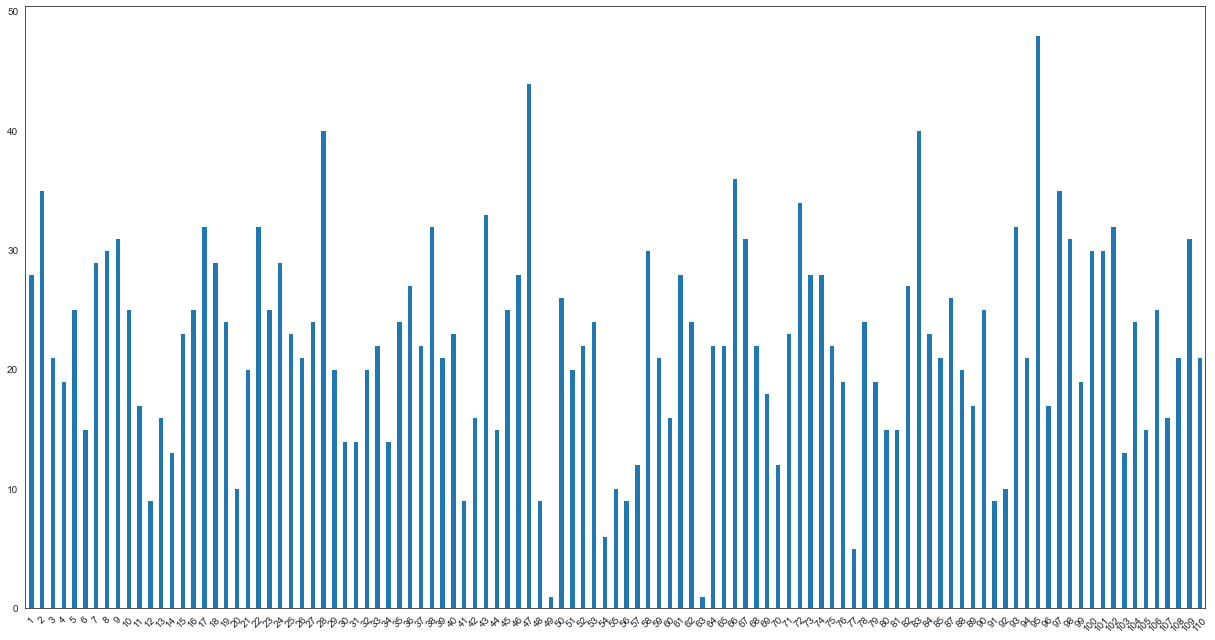

In [67]:
df.nchunks.plot.bar(figsize=(17,9),rot=45)
plt.tight_layout()
print("Mean and std of number of chunks {:4.1f} {:4.1f}".format(np.mean(df.nchunks.values),np.std(df.nchunks.values)))

#### Ranking of the books by number of chunks

In [68]:
df[['title', 'author','source','nchunks','nWords','nChar','nsentences']].sort_values('nchunks',ascending=False)

,title,author,source,nchunks,nWords,nChar,nsentences
95,La Celestina,"Rojas, Fernando de",spanish,48,104146,485274,4849
47,La cuerda del ahorcado\nÚltimas aventuras de R...,Ponson du Terrail,french,44,74472,337991,4406
83,Nacha Regules: Novela,"Gálvez, Manuel",spanish,40,79319,365921,4097
28,Retrato de la Lozana Andaluza\nEn lengua españ...,"Delicado, Francisco, active 16th century",spanish,40,67542,277128,4015
66,Los Ladrones de Londres,"Dickens, Charles",english,36,111373,508162,3630
...,...,...,...,...,...,...,...
56,Oasis en la vida,"Gorriti, Juana Manuela",spanish,9,14644,67598,954
54,Platero y yo,"Jiménez, Juan Ramón",spanish,6,12101,52639,672
77,Novelas de Voltaire — Tomo Primero,Voltaire,french,5,17380,78204,590
49,Ratón Pérez: cuento infantil,"Coloma, Luis",spanish,1,4144,18531,129


1    1536
0     890
Name: original_es, dtype: int64


spanish    1536
french      514
english     206
italian      73
russian      67
german       30
Name: source, dtype: int64




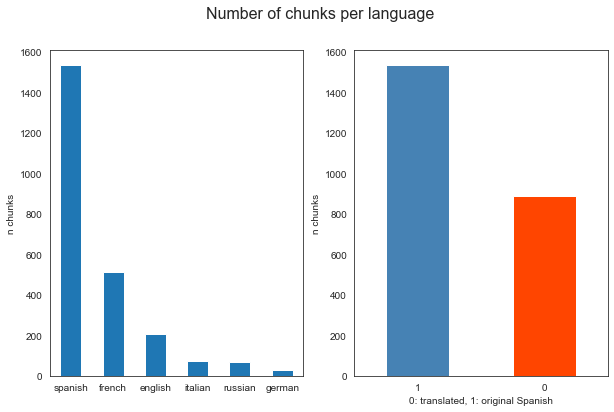

In [69]:
# Number of chunks for each language
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
df_chunk.source.value_counts().plot.bar(ax=axes[0],rot=0)
df_chunk.original_es.value_counts().plot.bar(ax=axes[1],color=['steelblue','orangered'],rot=0)
axes[1].set_xlabel("0: translated, 1: original Spanish")
axes[0].set_ylabel("n chunks")
axes[1].set_ylabel("n chunks")
fig.suptitle('Number of chunks per language', fontsize=16)
print(df_chunk.original_es.value_counts())
print('\n')
print(df_chunk.source.value_counts())
print('\n')

In [70]:
dfSum=df_chunk[['nWords','nChars','source']].groupby('source').aggregate(sum)
dfSum=pd.concat([dfSum, pd.DataFrame(dfSum.sum()).transpose()])
dfSum.index=list(dfSum.index)[:-1]+ ['TOTAL']
dfSum

,nWords,nChars
english,411514,1885131
french,1000708,4554930
german,45924,203914
italian,134300,610657
russian,92175,425760
spanish,3170512,14376802
TOTAL,4855133,22057194


array([<AxesSubplot:ylabel='nWords'>, <AxesSubplot:ylabel='nChars'>],
      dtype=object)

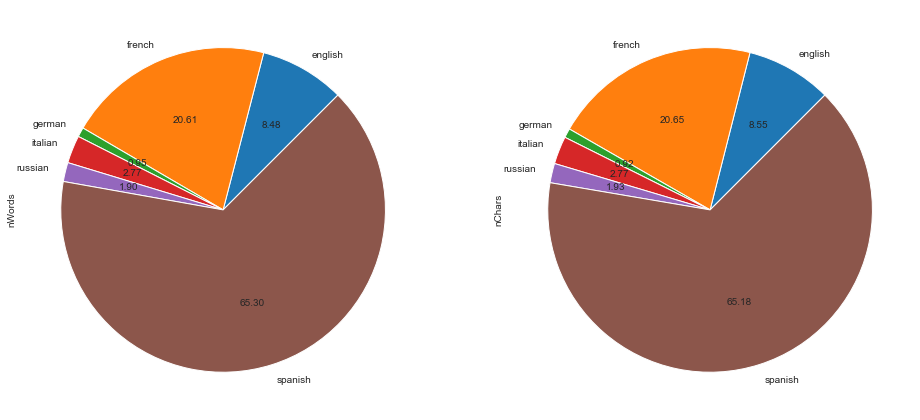

In [71]:
# No matter if we look in terms of number of words or characters, the proportions are the same
df_chunk[['nWords','nChars','source']].groupby('source').aggregate(sum).plot.pie(
     subplots=True,legend=False,figsize=(16,8),labeldistance=1.1,startangle=45,autopct=lambda x:f"{x:2.2f}")

In [72]:
# 0 lines have Nan vor the variance of the variance of word len
df_chunk[df_chunk.isnull().any(axis=1)]

,author,title,source,original_es,nWords,nChars,avWordLen,varWordlen,fPunct,nSmallWords,nLongWords,nWordsMEAN_SENT,nCharsMEAN_SENT,avWordLenMEAN_SENT,varWordlenMEAN_SENT,fPunctMEAN_SENT,nSmallWordsMEAN_SENT,nLongWordsMEAN_SENT,nWordsVAR_SENT,nCharsVAR_SENT,avWordLenVAR_SENT,varWordlenVAR_SENT,fPunctVAR_SENT,nSmallWordsVAR_SENT,nLongWordsVAR_SENT,spanList


In [73]:
# Importing various classifiers
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

# Scoring
from sklearn.metrics import roc_auc_score

### Let's see if we can train a classifier on these basic features

In [74]:
# Importing various classifiers
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

# Scoring
from sklearn.metrics import roc_auc_score

In [75]:
# Creating X and y (So far we have 21 features)
X= df_chunk[chunk_features].values.astype('float32')
y= df_chunk['original_es'].values.astype('int')

print('X shape', X.shape)
print('y shape', y.shape)

X shape (2426, 21)
y shape (2426,)


In [76]:
# Checking 
y

array([1, 1, 1, ..., 0, 0, 0])

In [77]:
# TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [78]:
clfDict={'Logistic Regression':LogisticRegression(), 
         'Random Forest':RandomForestClassifier(n_estimators=100), 
         'Gradient Boosting':GradientBoostingClassifier(n_estimators=100),
         'SVM':SVC(),
         'Naive Bayes':GaussianNB()}

for i,(method,clf) in enumerate(clfDict.items()):
    print(i+1,')',method)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print(classification_report(y_test,y_pred))
    print("ROC_AUC",roc_auc_score(y_test,y_pred))
    print('-------------------------------------\n')

1 ) Logistic Regression
              precision    recall  f1-score   support

           0       0.39      0.08      0.13       178
           1       0.64      0.93      0.75       308

    accuracy                           0.62       486
   macro avg       0.51      0.50      0.44       486
weighted avg       0.55      0.62      0.53       486

ROC_AUC 0.5036115569823435
-------------------------------------

2 ) Random Forest
              precision    recall  f1-score   support

           0       0.66      0.53      0.59       178
           1       0.76      0.84      0.80       308

    accuracy                           0.73       486
   macro avg       0.71      0.69      0.69       486
weighted avg       0.72      0.73      0.72       486

ROC_AUC 0.6861228658981467
-------------------------------------

3 ) Gradient Boosting
              precision    recall  f1-score   support

           0       0.68      0.49      0.57       178
           1       0.75      0.86      0.

/home/nicolas/anaconda3/envs/gutemberg/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## MORE FEATURES!

### Transforming the text: WORD -> GRAMMATICAL FUNCTION

The goal here is to tranform the text into grammatical tags in the hope to see differences in structures between original and translated texts, this is possible thanks to sophisticated NLP libraries lke Spacy, which understand word function.

### Examples

In [79]:
# Playing with spacy
doc= nlp(u"Me gusta el cafe con leche y las manzanas.")

In [80]:
# Each word becomes a token
for token in doc:
    # part of speech and syntactic dependency, lemmatization, most common words in language
    print(token.text, token.pos_, token.dep_, token.lemma_, token.is_stop, token.shape_) 

Me PRON obj Me True Xx
gusta VERB ROOT gustar False xxxx
el DET det el True xx
cafe NOUN nsubj cafe False xxxx
con ADP case con True xxx
leche NOUN nmod leche False xxxx
y CCONJ cc y False x
las DET det los True xxx
manzanas NOUN conj manzana False xxxx
. PUNCT punct . False .


In [81]:
doc= nlp(u"He comprado mi viaje a Valencia en el Corte Inglés.")

In [82]:
for entity in doc.ents:
    print(entity,entity.label_)

Valencia LOC
Corte Inglés LOC


In [83]:
# LEMMATIZATION (stemming words in their context)
for token in doc:
    print(token.text,token.lemma_)

He He
comprado comprar
mi mi
viaje viajar
a a
Valencia Valencia
en en
el el
Corte Corte
Inglés Inglés
. .


### PROCESSING ALL TEXTS

### Saving

In [84]:
# saving
#saved= "../data/df/df_pos5.pkl"
#df.to_pickle(saved) 

### For each chunk, transform the list of spans into pos_ dep_ word

In [85]:
df_chunk.iloc[0].spanList

[el sobrino de coletilla vii.,
 la voz interior viii.,
 hoy llega ix.,
 los primeros pasos x. la primera batalla xi.,
 la tragedia de los gracos xii.,
 la batalla de platerías xiii.,
 no llega el esperado.,
 llegada de un importuno xiv.,
 la determinación xv.,
 las tres ruinas xvi.,
 el siglo décimoctavo xvii.,
 el sueño del liberal xviii.,
 diálogo entre ayer y hoy xix.,
 el abate xx.,
 bozmediano xxi.,
 ¡libre! xxii.,
 el vía-crucis de lázaro xxiii.,
 la inquisición xxiv.,
 rosa mística xxv.,
 virgo prudentísima xxvi.,
 los disidentes de la fontana xxvii.,
 se queda sola xxviii.,
 el ridículo xxix.,
 las horas fatales xxx.,
 virgo fidelis xxxi.,
 la reunión misteriosa xxxii.,
 la fontanilla xxxiii.,
 las arpías se ponen tristes xxxiv.,
 el complot.,
 triunfo de lázaro xxxv.,
 el bonete del nuncio xxxvi.,
 aclaraciones xxxvii.,
 el vía-crucis de clara xxxviii.,
 continuación del vía-crucis xxxix.,
 un momento de calma xl.,
 el gran atentado xli.,
 fernando el deseado xlii.,
 virgo pot

In [86]:
df_chunk['grammar']= df_chunk.spanList.apply(lambda li:' '.join([span2grammar(sp) for sp in li]))

In [87]:
df_chunk.iloc[10].grammar

'ADV_advmod ADP_case DET_det NOUN_obl ADP_case DET_det NOUN_nmod CCONJ_cc PROPN_conj ADV_advmod VERB_ROOT NUM_nummod NOUN_nsubj NUM_nummod NOUN_appos ADJ_amod SCONJ_nsubj VERB_acl NOUN_obj ADJ_amod ADP_case DET_det NOUN_amod ADV_advmod ADP_case ADV_advmod ADP_case ADV_obl VERB_aux ADP_mark VERB_ROOT AUX_ROOT DET_det NOUN_obj ADJ_amod VERB_cop ADJ_advcl ADJ_amod ADJ_conj ADV_advmod AUX_ROOT ADP_case PROPN_obj CCONJ_cc ADP_case NOUN_conj ADJ_amod SCONJ_nsubj AUX_acl NOUN_obj CCONJ_cc AUX_conj DET_det NOUN_obj ADV_advmod VERB_aux VERB_ROOT ADP_case DET_det NOUN_obj CCONJ_cc INTJ_advmod ADV_advmod ADP_case DET_det ADJ_amod NOUN_obl CCONJ_cc VERB_cop ADV_advmod ADJ_conj CCONJ_cc ADJ_conj SCONJ_nsubj ADJ_nsubj PRON_obj AUX_acl ADP_mark VERB_xcomp NOUN_obj SCONJ_mark ADV_mark SCONJ_fixed AUX_advcl ADP_case DET_det NOUN_obl AUX_advcl ADV_advmod DET_det NOUN_obj ADP_case NOUN_nmod SCONJ_nsubj AUX_acl DET_det NOUN_obj ADP_case DET_det NOUN_obl ADP_case DET_det NOUN_nmod ADP_case DET_det ADJ_amod

### Vectorization

Now we will numerize these lists of grammar terms by performing counts

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Here we try both TfIdf and a simpler countVectorizer
# In the end results were slightly better with a count vectorizer

#vect=TfidfVectorizer()
vect=CountVectorizer()

Xdtm = vect.fit_transform(df_chunk.grammar.values)
Xdtm=Xdtm.toarray()
Xdtm = Xdtm.astype('float32') 
Xdtm.shape

(2426, 388)

Done in a few seconds! We hae 404 more dimensions to our dataset now

In [89]:
# Take our old matrix add stack those new features
X.shape

(2426, 21)

In [90]:
# stacking the column of chunk length (adding one more feature)
Xdtm2 =np.hstack((Xdtm,X))
Xdtm2.shape

(2426, 409)

### Keeping 20% of the text chunks for testing

In [91]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xdtm2, y, test_size=0.2, random_state=42, stratify=y)
len(y)

2426

In [92]:
clfDict={'Logistic Regression':LogisticRegression(), 
         'Random Forest':RandomForestClassifier(), 
         'Gradient Boosting':GradientBoostingClassifier(),
         'SVM':SVC(),
         'Naive Bayes':GaussianNB()}

for i,(method,clf) in enumerate(clfDict.items()):
    print(i+1,')',method)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print(classification_report(y_test,y_pred))
    print("ROC_AUC",roc_auc_score(y_test,y_pred))
    print('-------------------------------------\n')

1 ) Logistic Regression
              precision    recall  f1-score   support

           0       0.72      0.65      0.69       178
           1       0.81      0.86      0.83       308

    accuracy                           0.78       486
   macro avg       0.77      0.75      0.76       486
weighted avg       0.78      0.78      0.78       486

ROC_AUC 0.7544141252006421
-------------------------------------

2 ) Random Forest


/home/nicolas/anaconda3/envs/gutemberg/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.81      0.60      0.69       178
           1       0.80      0.92      0.85       308

    accuracy                           0.80       486
   macro avg       0.80      0.76      0.77       486
weighted avg       0.80      0.80      0.79       486

ROC_AUC 0.7571683934043484
-------------------------------------

3 ) Gradient Boosting
              precision    recall  f1-score   support

           0       0.85      0.68      0.75       178
           1       0.83      0.93      0.88       308

    accuracy                           0.84       486
   macro avg       0.84      0.80      0.82       486
weighted avg       0.84      0.84      0.83       486

ROC_AUC 0.8041733547351525
-------------------------------------

4 ) SVM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       178
           1       0.63      1.00      0.78       308

    accuracy        

/home/nicolas/anaconda3/envs/gutemberg/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Hyper parameter optimization

In [93]:
# Using hyperopt as an alternative to GridSearchCV (slow in this case)
# conda install -c conda-forge hyperopt 
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [94]:
# Parameter space
param_space = {
    
    "loss":hp.choice("loss",("deviance","exponential")),
    "learning_rate": hp.choice("learning_rate",(0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2)),
    "min_samples_split": hp.choice("min_samples_split",np.linspace(0.1, 0.5, 12)),
    "min_samples_leaf":hp.choice("min_samples_leaf", np.linspace(0.1, 0.5, 12)),
    "max_depth":hp.choice("max_depth",(3,5,8)),
    "max_features": hp.choice("max_features",('sqrt','log2')),
    "subsample":hp.choice("subsample",(0.5, 1)),
    "n_estimators":hp.choice("n_estimators", (100,500,1000, 1500,2000)) 
                }

In [95]:
#from sklearn.model_selection import cross_val_score

# I just copy again the code this function for easier readability
def rocModel(loss, learning_rate, min_samples_split, min_samples_leaf, max_depth, max_features, subsample, n_estimators):
    
    clf= GradientBoostingClassifier(loss=loss, learning_rate=learning_rate, min_samples_split=min_samples_split, 
                                   min_samples_leaf=min_samples_leaf, max_depth=max_depth, 
                                   max_features=max_features, subsample=subsample,
                                   n_estimators=n_estimators)
    clf.fit(X_train,y_train)
    y_hat= clf.predict(X_test)
    
    return roc_auc_score(y_test,y_hat)

best = 0
best_param=dict()
def f(params):
    global best,best_param
    acc = rocModel(**params)
    if acc > best:
        best = acc
        best_param=params.copy()
    print ('new best:', best)
    print("BEST PARAM",best_param)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=3000, trials=trials)
print ('best:')
print (best)



new best:                                               
0.7153983656792645                                      
BEST PARAM                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.46363636363636374, 'min_samples_split': 0.5, 'n_estimators': 1000, 'subsample': 1}
new best:                                                                          
0.7153983656792645                                                                 
BEST PARAM                                                                         
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.46363636363636374, 'min_samples_split': 0.5, 'n_estimators': 1000, 'subsample': 1}
new best:                                                                          
0.7384357215817889                                                                 
BEST PARAM                       

0.7975521669341894                                                                  
BEST PARAM                                                                          
{'learning_rate': 0.025, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.17272727272727273, 'min_samples_split': 0.3545454545454546, 'n_estimators': 1000, 'subsample': 1}
new best:                                                                           
0.7975521669341894                                                                  
BEST PARAM                                                                          
{'learning_rate': 0.025, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.17272727272727273, 'min_samples_split': 0.3545454545454546, 'n_estimators': 1000, 'subsample': 1}
new best:                                                                           
0.8083503575076608                                                              

new best:                                                                             
0.8356923974901502                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.075, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.13636363636363638, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                             
0.8356923974901502                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.075, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.13636363636363638, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                         

{'learning_rate': 0.075, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.13636363636363638, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                             
0.8356923974901502                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.075, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.13636363636363638, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                             
0.8356923974901502                                                                  
BEST PARAM                                                                          
{'learning_rate': 0.075, 'loss': 'deviance', 'max_depth': 3, 'max_feat

BEST PARAM                                                                            
{'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                             
0.8445571282649935                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                             
0.8445571282649935                                                                    
BEST PARAM                                                                            
{'learnin

BEST PARAM                                                                            
{'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                             
0.8445571282649935                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                             
0.8445571282649935                                                                    
BEST PARAM                                                                            
{'learnin

BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              
0.8478038815117468                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              
0.8478038815117468                                                                     
BEST PARAM                                                                             


0.8478038815117468                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              
0.8478038815117468                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              
0.8478038815117468                                                                     


0.8478038815117468                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              
0.8478038815117468                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              
0.8478038815117468                                                                     


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                   
BEST PARAM                                                                           
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.85

new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8513607179337517                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.17272727272727273, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              
0.8534218590398365                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 1500, 'subsample': 1}
new best:                                                                              


new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562

new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562

new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562

new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562

new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562

new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562308478038816                                                                   
BEST PARAM                                                                           
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                            
0.8562308478

new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562

new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562

new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562

new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562

new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562

new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562

new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562

new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562308478038816                                                                     
BEST PARAM                                                                             
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                              
0.8562

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                             
0.8562308478038816                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                             
0.856

new best:                                                                               
0.8562308478038816                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                             
0.8562308478038816                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                             
0.8562308478038816                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.856

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                             
0.8562308478038816                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                             
0.856230847

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                             
0.8562308478038816                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.856

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                             
0.8562308478038816                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                             
0.8562308478038816                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.856230847

new best:                                                                               
0.8562308478038816                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8

new best:                                                                             
0.8562308478038816                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                             
0.8562308478038816                                                                    
BEST PARAM                                                                            
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                             
0.85623084780

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                                 
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8562308478038816                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                       

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8562308478038816                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                         

new best:                                                                                 
0.8562308478038816                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                       

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8562308478038816                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8562308478038816                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 

0.8562308478038816                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8562308478038816                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8562308478038816                                                          

new best:                                                                                 
0.8562308478038816                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                       

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               

new best:                                                                                 
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8562308478038816                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                       

new best:                                                                               
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8562308478038816                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                         

new best:                                                                                 
0.8562308478038816                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8562308478038816                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                       

{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8614110608492631                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8614110608492631                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sq

BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8614110608492631                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8614110608492631                                                                        
BEST PARAM                                                                      

0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
B

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                                 
0.8614110608492631                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8614110608492631                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                     

{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8614110608492631                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8614110608492631                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sq

0.8614110608492631                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8614110608492631                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8614110608492631                                                            

new best:                                                                                 
0.8614110608492631                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                                 
0.8614110608492631                                                                        
BEST PARAM                                                                                
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                     

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0.8614110608492631                                                                      
BEST PARAM                                                                              
{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'n_estimators': 2000, 'subsample': 1}
new best:                                                                               
0

### Gradient Boosting seems to perform best here, try to optimize the hyperparameters

In [96]:
bestparam={'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.2090909090909091, 'n_estimators': 1500, 'subsample': 1}
bestclf= GradientBoostingClassifier(**bestparam)
bestclf.fit(X_train,y_train)
y_pred=bestclf.predict(X_test)
print(classification_report(y_test,y_pred))
print("ROC_AUC",roc_auc_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       178
           1       0.88      0.90      0.89       308

    accuracy                           0.86       486
   macro avg       0.85      0.84      0.85       486
weighted avg       0.86      0.86      0.86       486

ROC_AUC 0.8417481395009485


In [100]:
# Saving the model
modelFile="../data/MLmodels/gradboost161220BEST.pkl"
if not os.path.exists(modelFile):
    joblib.dump(bestclf, modelFile)
else:
    print(modelFile,"alreday exists!")

## Building a predictor for new documents

In [98]:
new_text="""
Me miro en el espejo y frunzo el ceño, frustrada. Qué asco de pelo. No hay manera
con él. Y maldita sea Katherine Kavanagh, que se ha puesto enferma y me ha
metido en este lío. Tendría que estar estudiando para los exámenes finales, que son
la semana que viene, pero aquí estoy, intentando hacer algo con mi pelo. No debo
meterme en la cama con el pelo mojado. No debo meterme en la cama con el pelo
mojado. Recito varias veces este mantra mientras intento una vez más controlarlo
con el cepillo. Me desespero, pongo los ojos en blanco, después observo a la chica
pálida, de pelo castaño y ojos azules exageradamente grandes que me mira, y me
rindo. Mi única opción es recogerme este pelo rebelde en una coleta y confiar en
estar medio presentable.
Kate es mi compañera de piso, y ha tenido que pillar un resfriado precisamente
hoy. Por eso no puede ir a la entrevista que había concertado para la revista de la
facultad con un megaempresario del que yo nunca había oído hablar. Así que va a
tocarme a mí. Tengo que estudiar para los exámenes finales, tengo que terminar un
trabajo y se suponía que a eso iba a dedicarme esta tarde, pero no. Lo que voy a
hacer esta tarde es conducir más de doscientos kilómetros hasta el centro de Seattle
para reunirme con el enigmático presidente de Grey Enterprises Holdings, Inc.
Como empresario excepcional y principal mecenas de nuestra universidad, su
tiempo es extraordinariamente valioso —mucho más que el mío—, pero ha
concedido una entrevista a Kate. Un bombazo, según ella. Malditas sean sus
actividades extraacadémicas.
Kate está acurrucada en el sofá del salón.
—Ana, lo siento. Tardé nueve meses en conseguir esta entrevista. Si pido que
me cambien el día, tendré que esperar otros seis meses, y para entonces las dos
estaremos graduadas. Soy la responsable de la revista, así que no puedo echarlo
todo a perder. Por favor… —me suplica Kate con voz ronca por el resfriado.
¿Cómo lo hace? Incluso enferma está guapísima, realmente atractiva, con su
pelo rubio rojizo perfectamente peinado y sus brillantes ojos verdes, aunque ahora
los tiene rojos y llorosos. Paso por alto la inoportuna punzada de lástima que me
inspira.

—Claro que iré, Kate. Vuelve a la cama. ¿Quieres una aspirina o un
paracetamol?
—Un paracetamol, por favor. Aquí tienes las preguntas y la grabadora. Solo
tienes que apretar aquí. Y toma notas. Luego ya lo transcribiré todo.
—No sé nada de él —murmuro intentando en vano reprimir el pánico, que es
cada vez mayor.
—Te harás una idea por las preguntas. Sal ya. El viaje es largo. No quiero que
llegues tarde.
—Vale, me voy. Vuelve a la cama. Te he preparado una sopa para que te la
calientes después.
La miro con cariño. Solo haría algo así por ti, Kate.
—Sí, lo haré. Suerte. Y gracias, Ana. Me has salvado la vida, para variar.
Cojo el bolso, le lanzo una sonrisa y me dirijo al coche. No puedo creerme que
me haya dejado convencer, pero Kate es capaz de convencer a cualquiera de lo que
sea. Será una excelente periodista. Sabe expresarse y discutir, es fuerte, convincente
y guapa. Y es mi mejor amiga.
Apenas hay tráfico cuando salgo de Vancouver, Washington, en dirección a la
interestatal 5. Es temprano y no tengo que estar en Seattle hasta las dos del
mediodía. Por suerte, Kate me ha dejado su Mercedes CLK. No tengo nada claro
que pudiera llegar a tiempo con Wanda, mi viejo Volkswagen Escarabajo.
Conducir el Mercedes es muy agradable. Piso con fuerza el acelerador, y los
kilómetros pasan volando.
Me dirijo a la sede principal de la multinacional del señor Grey, un enorme
edificio de veinte plantas, una fantasía arquitectónica, todo él de vidrio y acero, y
con las palabras GREY HOUSE en un discreto tono metálico en las puertas
acristaladas de la entrada. Son las dos menos cuarto cuando llego. Entro en el
inmenso —y francamente intimidante— vestíbulo de vidrio, acero y piedra blanca,
muy aliviada por no haber llegado tarde.
Desde el otro lado de un sólido mostrador de piedra me sonríe amablemente
una chica rubia, atractiva y muy arreglada. Lleva la americana gris oscura y la
falda blanca más elegantes que he visto jamás. Está impecable.
—Vengo a ver al señor Grey. Anastasia Steele, de parte de Katherine Kavanagh.
—Discúlpeme un momento, señorita Steel —me dice alzando las cejas.
Espero tímidamente frente a ella. Empiezo a pensar que debería haberme puesto

una americana de vestir de Kate en lugar de mi chaqueta azul marino. He hecho
un esfuerzo y me he puesto la única falda que tengo, mis cómodas botas marrones
hasta la rodilla y un jersey azul. Para mí ya es ir elegante. Me paso por detrás de la
oreja un mechón de pelo que se me ha soltado de la coleta fingiendo no sentirme
intimidada.
—Sí, tiene cita con la señorita Kavanagh. Firme aquí, por favor, señorita Steel. El
último ascensor de la derecha, planta 20.
Me sonríe amablemente, sin duda divertida, mientras firmo.
Me tiende un pase de seguridad que tiene impresa la palabra VISITANTE. No
puedo evitar sonreír. Es obvio que solo estoy de visita. Desentono completamente.
No pasa nada, suspiro para mis adentros. Le doy las gracias y me dirijo hacia los
ascensores, más allá de los dos vigilantes, ambos mucho más elegantes que yo con
su traje negro de corte perfecto.
El ascensor me traslada a la planta 20 a una velocidad de vértigo. Las puertas se
abren y salgo a otro gran vestíbulo, también de vidrio, acero y piedra blanca. Me
acerco a otro mostrador de piedra y me saluda otra chica rubia vestida
impecablemente de blanco y negro.
—Señorita Steele, ¿puede esperar aquí, por favor? —me pregunta señalándome
una zona de asientos de piel de color blanco.
Detrás de los asientos de piel hay una gran sala de reuniones con las paredes de
vidrio, una mesa de madera oscura, también grande, y al menos veinte sillas a
juego. Más allá, un ventanal desde el suelo hasta el techo que ofrece una vista de
Seattle hacia el Sound. La vista es tan impactante que me quedo
momentáneamente paralizada. Uau.
Me siento, saco las preguntas del bolso y les echo un vistazo maldiciendo por
dentro a Kate por no haberme pasado una breve biografía. No sé nada del hombre
al que voy a entrevistar. Podría tener tanto noventa años como treinta. La
inseguridad me mortifica y, como estoy nerviosa, no paro de moverme. Nunca me
he sentido cómoda en las entrevistas cara a cara. Prefiero el anonimato de una
charla en grupo, en la que puedo sentarme al fondo de la sala y pasar inadvertida.
Para ser sincera, lo que me gusta es estar sola, acurrucada en una silla de la
biblioteca del campus universitario leyendo una buena novela inglesa, y no
removiéndome en el sillón de un enorme edificio de vidrio y piedra.
Suspiro. Contrólate, Steele. A juzgar por el edificio, demasiado aséptico y
moderno, supongo que Grey tendrá unos cuarenta años. Un tipo que se mantiene
en forma, bronceado y rubio, a juego con el resto del personal.
"""

In [101]:
# Here we use our already fitted vectorizer to transform new data
def predictor(textInput):
    
    # 1) Cut you text into chunks of 100 sentences
    listSent= [s for s in nlp(textInput).sents]
    #print('listSent',listSent)
    if len(listSent)<CHUNK_LEN:
        print("Please provide a text with at least "+str(CHUNK_LEN)+"sentences")
        return -1
    
    
    # 2) Calculate the basic properties
    chunk_feat = aggrItems(listSent,chunk_len=CHUNK_LEN)[0] 
    #print('chunk_feat',chunk_feat)
    
    
    # 3) Turn the text into grammatical relationships
    Xbasic= np.array(chunk_feat[:-1],dtype=np.float32) # we don't need the list of spans
    Xbasic=Xbasic.reshape(1,len(Xbasic))
    print('Xbasic', Xbasic)
    
    grammar= ' '.join([span2grammar(sp) for sp in chunk_feat[-1]])
    print('Grammar', grammar)

    # 4) Vectorize the grammatical relationships and add them to the basic properties
    
    Xdtm_new= vect.transform([grammar])  # First document term matrix
    Xdtm_new=Xdtm_new.toarray()              # sparse matrix -> numpy array
    Xdtm_new = Xdtm_new.astype('float32')
    
    print('Xdtm_new',Xdtm_new)
    print(Xbasic.shape)
    print(Xdtm_new.shape)
    
    # 5) concatenate basic and grammatical features
    Xtest= np.hstack((Xdtm_new,Xbasic))
    
    # 6) Now the prediction
    return bestclf.predict(Xtest)
    
predictor(new_text)

Xbasic [[1.1250000e+03 5.1020000e+03 4.5351110e+00 7.3758783e+00 3.3908270e-02
  5.8666665e-02 5.6000002e-02 1.1250000e+01 5.1020000e+01 4.5246544e+00
  5.9332099e+00 5.5818014e-02 5.5530004e-02 5.6151830e-02 6.8067497e+01
  1.5121196e+03 1.3370951e+00 1.4389170e+01 3.0686902e-03 6.3689058e-03
  8.9592263e-03]]
Grammar PRON_obj VERB_ROOT ADP_case DET_det NOUN_obl CCONJ_cc PROPN_conj DET_det NOUN_obj ADJ_amod DET_det NOUN_ROOT ADP_case NOUN_nmod ADV_advmod AUX_ROOT NOUN_obj ADP_case PRON_obl CCONJ_advmod VERB_ROOT VERB_cop PROPN_nsubj PROPN_flat SCONJ_nsubj PRON_obj AUX_aux VERB_acl NOUN_obj CCONJ_cc PRON_obj AUX_aux ADJ_conj ADP_case DET_det NOUN_obl VERB_ROOT SCONJ_cc VERB_aux VERB_conj ADP_case DET_det NOUN_obl ADJ_amod SCONJ_nsubj VERB_acl DET_det NOUN_obl SCONJ_nsubj VERB_acl CCONJ_cc ADV_advmod AUX_conj AUX_advcl VERB_xcomp PRON_obj ADP_case DET_det NOUN_obl ADV_advmod AUX_ROOT VERB_xcomp ADP_case DET_det NOUN_obl ADP_case DET_det NOUN_obl ADJ_amod ADV_advmod AUX_aux VERB_ROOT ADP

array([0])

### TO GO FURTHER

- Deep learning to guess the source language
- Include more (curated) data
- Try to interpret the model
- make a Docker image
- Check if we can differentiate different flavours of Spanish
- etc